# 이웃집 토토치 파이토치 : Day 3

📢 해당 게시물은 파이토치 공식 튜토리얼 중 
[DATASET과 DATALOADER](https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html)와 
[분류기(CLASSIFIER) 학습하기](https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
[모델 저장하고 불러오기](https://tutorials.pytorch.kr/beginner/saving_loading_models.html)
를 읽고 직접 작성해보는 실습 노트북입니다.  

#### 목차
1. DATASET과 DATALOADER
    1. 필요 모듈 준비
    2. Configration 설정
    3. 데이터 준비
2. Pytorch로 구현하는 MNIST 손글씨 분류기
    1. 도우미 함수 정의
    2. 모델 정의하기
    3. 학습 진행하기
    4. Batch Norm 적용하고 학습하기
3. 모델 저장하고 불러오기
    1. 모델 전제 저장
    2. 모델의 state_dict만 저장


# 1. DATASET과 DATALOADER
---

데이터 샘플을 처리하는 코드는 지저분(messy)하고 유지보수가 어려울 수 있습니다. 더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적입니다. PyTorch는 ``torch.utils.data.DataLoader``와 ``torch.utils.data.Dataset`` 의 두 가지 데이터 기본 요소를 제공하여 미리 준비해된(pre-loaded) 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 합니다.
``Dataset`` 은 샘플과 정답(label)을 저장하고, ``DataLoader`` 는 ``Dataset`` 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감쌉니다.

PyTorch의 도메인 특화 라이브러리들은 (FashionMNIST와 같은) 다양한 미리 준비해둔(pre-loaded) 데이터셋을 제공합니다. 데이터셋은 ``torch.utils.data.Dataset`` 의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있습니다. 이러한 데이터셋은 모델을 만들어보고(prototype) 성능을 측정(benchmark)하는데 사용할 수 있습니다.

여기에서 데이터셋들을 찾아볼 수 있습니다:
[이미지 데이터셋](https://pytorch.org/vision/stable/datasets.html), 
[텍스트 데이터셋](https://pytorch.org/text/stable/datasets.html) 및
[오디오 데이터셋](https://pytorch.org/audio/stable/datasets.html)

## 1) 필요 모듈 준비

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn    
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset


## 2) Configration 설정

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCH = 10
BATCH_SIZE = 128
FC_LAYER_SIZE = 128
LR = 0.01
DROOUT = 0.5
OPTIMIZER = 'sgd'

## 3) 데이터 준비

### 3-1) 기존 TorchVision Data Pipeline

In [3]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomRotation(degrees=45),
                                      transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                      transforms.Normalize([0.5,],[0.5,])])
test_transform = transforms.Compose([ transforms.ToTensor(),
                                      transforms.Normalize([0.5,],[0.5])])

train_dataset = datasets.MNIST(root = '../MNIST', # 데이터 저장될장소 
                               train = True, # train인지 test인지 
                               download = True,# 인터넷에서 다운로드해 이용할건지 
                               transform = train_transform) 

test_dataset = datasets.MNIST(root = '../MNIST', train = False,
                               download = True, transform = test_transform)

# Subset을 사용하면 Dataset의 부분 집합만 가져올 수 있음.
train_sub_dataset = Subset(train_dataset, indices=range(0, len(train_dataset), 5))
test_sub_dataset = Subset(test_dataset, indices=range(0, len(test_dataset), 5))

train_loader = DataLoader(dataset = train_sub_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = True)

test_loader = DataLoader(dataset = test_sub_dataset,
                         batch_size = BATCH_SIZE)

C:\Users\pebpung\anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Subset은 Dataset의 부분 집합을 가져오는 함수입니다.  
Dataset 원본으로 학습을 시켰을 경우 16~17분 정도가 걸리지만, Subset으로 학습을 할 경우 3~4분 정도가 걸립니다. 

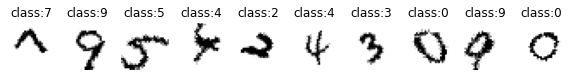

In [4]:
X_train, y_train = next(iter(train_loader))

pltsize = 1
plt.figure(figsize = (10 * pltsize ,pltsize))
for i in range(10):
  plt.subplot(1, 10 , i + 1)
  plt.axis('off')
  plt.imshow(X_train[i, : , :, :].numpy().reshape(28,28), cmap = 'gray_r')
  plt.title('class:' + str(y_train[i].item()))

### 3-2) 다양한 transforms 적용해보기

🔎 다양한 transforms 추가해서 Mnist 데이터셋을 변형해봅시다!   
👉 (3-1에서 train_transform, test_transform를 바꿔보시길 바랍니다.)  
🔔 [Hint](https://pytorch.org/vision/stable/transforms.html)

### 3-3) 더 빠른 augmentation, albumentations 

🔎 Albumentations의 장점과 특징은 어떤게 있을까요?  
👉 (괄호를 지우고 적어주세요!)   
🔔 [Hint](https://hoya012.github.io/blog/albumentation_tutorial/) 

# 2. Pytorch로 구현하는 MNIST 손글씨 분류기
---
우리는 위에서 DATASET과 DATALOADER를 살펴보았습니다.  
이번에는 Pytorch로 MNIST를 학습하는 코드를 적용해보겠습니다.  
마찬가지로 중간중간에 있는 문제를 푸시면 됩니다!

## 1) 도우미 함수 정의

In [5]:
def train_epoch(network, loader, optimizer, criterion):
    cumu_loss = 0
    cumu_acc = 0
    total = 0

    for _, (data, target) in enumerate(loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()

        loss = criterion(network(data), target)
        cumu_loss += loss.item()
        _, predicted = torch.max(network(data).data, 1)
        total += target.size(0)
        cumu_acc += (predicted == target).sum().item()

        loss.backward()
        optimizer.step()
        network.eval() 
    return cumu_loss / len(loader), 100 * cumu_acc / total

In [6]:
def evaluate(model, test_loader, criterion):
  model.eval() # 모델을 평가상태(test 상태)로 지정 
  test_loss = 0 # test_loss 초기값 
  correct = 0 # 올바른 class로 분류한 카운트를 세기위해 0으로 설정 

  with torch.no_grad(): # 평가시에는 gradiant를 통해 패러미터 업데이트를 하지않음 
    for image, label in test_loader: # mini_batch 단위로 꺼내기 
      image = image.to(DEVICE) # DEVICE 할당
      label = label.to(DEVICE) # DEVICE에 할당
      output = model(image)    # 모델에 input을 넣어 output 계산 
      test_loss += criterion(output, label).item() # output과 label의 loss 계산 
      prediction = output.max(1, keepdim = True)[1] # output은 길이가 10인 벡터값 
                                                    # 그중에서 가장 큰값인 위치의 라벨로
                                                    # 예측햇다고 판단 
      correct += prediction.eq(label.view_as(prediction)).sum().item() # eq() 메서드는 라벨과 예측이 같으면(equal) 1
                                                                        # 다르면 0. 그 값들을더해서 correct에 더해주기 
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

## 2) 모델 정의하기

In [5]:
class ConvNet(nn.Module):
    def __init__(self, fc_layer_size, dropout):
        super(ConvNet, self).__init__() # nn.Module 의 init 상속
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer3 = nn.Sequential(
            nn.Linear(64 * 7 * 7, fc_layer_size, bias=True),
            nn.ReLU(),
            nn.Dropout2d(p=dropout))
        self.layer4 = nn.Sequential(
            nn.Linear(fc_layer_size, 84),
            nn.ReLU(),
            nn.Dropout2d(p=dropout))
        self.fc3 = nn.Linear(84, 10)

    # Forward Propagation 정의
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0),-1) 
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc3(x)
        return x

model = ConvNet(FC_LAYER_SIZE, DROOUT).to(DEVICE) 

## 3) 학습 진행하기

In [6]:
if OPTIMIZER == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
elif OPTIMIZER == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss() # Loss 기준은 CrossEntropyLoss로

**🔎 torch.optim에는 어떤 optimizer들을 구현할 수 있나요? ([공식 document](https://pytorch.org/docs/stable/optim.html?highlight=optim#module-torch.optim)를 참조하여 2개 이상 적어주세요.)**  
👉 대표적으로 ADAM, RMSprop등 다양한 optimizer가 있습니다. 또한 scheduler를 사용해서 학습 효율을 높일 수 있습니다

**🔎 nn.Module에서 활용할 수 있는 Loss function에는 어떤 것들이 있나요? ([공식 document-Loss function](https://pytorch.org/docs/stable/nn.html?highlight=loss#loss-functions)를 참조하여 2개 이상 적어주세요.)**  
👉 NLLLoss: null loss라고 읽었는데 알고보니 negative log likelihood loss이다.  
KLDivLoss: Kullback-Leibler divergence loss 이다. GAN에서 중요한 개념으로 사용된다.  
SmoothL1Loss: YOLOv1과 YOLOv2에서 활용된다. L1 loss와 L2 loss를 적절하게 혼합함.  

### 3-1) 기본 augmentation을 적용

In [58]:
for epoch in range(EPOCH):
    avg_loss, avg_acc = train_epoch(model, train_loader, optimizer, criterion)
    print(f"TRAIN: EPOCH {epoch + 1:04d} / {EPOCH:04d} | Epoch LOSS {avg_loss:.4f} | Epoch ACC {avg_acc:.2f}% ")

TRAIN: EPOCH 0001 / 0010 | Epoch LOSS 1.9152 | Epoch ACC 41.38% 
TRAIN: EPOCH 0002 / 0010 | Epoch LOSS 0.3931 | Epoch ACC 87.54% 
TRAIN: EPOCH 0003 / 0010 | Epoch LOSS 0.2097 | Epoch ACC 93.58% 
TRAIN: EPOCH 0004 / 0010 | Epoch LOSS 0.1493 | Epoch ACC 95.37% 
TRAIN: EPOCH 0005 / 0010 | Epoch LOSS 0.1046 | Epoch ACC 96.83% 
TRAIN: EPOCH 0006 / 0010 | Epoch LOSS 0.0897 | Epoch ACC 97.32% 
TRAIN: EPOCH 0007 / 0010 | Epoch LOSS 0.0689 | Epoch ACC 98.03% 
TRAIN: EPOCH 0008 / 0010 | Epoch LOSS 0.0607 | Epoch ACC 98.11% 
TRAIN: EPOCH 0009 / 0010 | Epoch LOSS 0.0527 | Epoch ACC 98.42% 
TRAIN: EPOCH 0010 / 0010 | Epoch LOSS 0.0454 | Epoch ACC 98.70% 


In [59]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test LOSS {test_loss:.4f} | Test ACC {test_accuracy:.2f}% ")

Test LOSS 0.0006 | Test ACC 97.90% 


### 3-2) RandomRotation, RandomAffine을 추가

In [9]:
for epoch in range(EPOCH):
    avg_loss, avg_acc = train_epoch(model, train_loader, optimizer, criterion)
    print(f"TRAIN: EPOCH {epoch + 1:04d} / {EPOCH:04d} | Epoch LOSS {avg_loss:.4f} | Epoch ACC {avg_acc:.2f}% ")

C:\Users\pebpung\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TRAIN: EPOCH 0001 / 0010 | Epoch LOSS 2.2399 | Epoch ACC 19.51% 
TRAIN: EPOCH 0002 / 0010 | Epoch LOSS 1.7524 | Epoch ACC 38.83% 
TRAIN: EPOCH 0003 / 0010 | Epoch LOSS 1.2340 | Epoch ACC 58.13% 
TRAIN: EPOCH 0004 / 0010 | Epoch LOSS 0.7992 | Epoch ACC 73.77% 
TRAIN: EPOCH 0005 / 0010 | Epoch LOSS 0.6238 | Epoch ACC 80.41% 
TRAIN: EPOCH 0006 / 0010 | Epoch LOSS 0.5233 | Epoch ACC 83.28% 
TRAIN: EPOCH 0007 / 0010 | Epoch LOSS 0.4151 | Epoch ACC 86.98% 
TRAIN: EPOCH 0008 / 0010 | Epoch LOSS 0.3697 | Epoch ACC 88.33% 
TRAIN: EPOCH 0009 / 0010 | Epoch LOSS 0.3327 | Epoch ACC 89.96% 
TRAIN: EPOCH 0010 / 0010 | Epoch LOSS 0.2974 | Epoch ACC 90.70% 


In [10]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test LOSS {test_loss:.4f} | Test ACC {test_accuracy:.2f}% ")

Test LOSS 0.0022 | Test ACC 91.55% 


train 학습 시에는 기본 augmentation을 적용한 것 보다 ACC가 낮아지지만, evaluate 시에는 더 좋아집니다.  
왜 이런 결과가 생겼을까요?  
데이터 증강은 train 학습 시에 성능 향상을 목적으로 하는 것이 아니기 때문입니다.  
더 다양한 모습의 데이터로 학습하여 새로 들어오는 test data에 대해서 robust 한 모델을 만드는 것이 목적이기 때문입니다.  
그래서 train acc 뿐만 아니라, valid acc를 추가해서 비교하는 것이 옳습니다.  

## 4) train, valid 함수 재정의

In [24]:
len(train_loader.dataset)

12000

In [24]:
def train(model, loader, optimizer, criterion):
    model.train()
    loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        output = model(data)
        loss = criterion(output, target)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx + 1)% 10 == 0:
            print(f'TRAIN EPOCH: {epoch + 1:04d} [{(batch_idx + 1) * len(data)} / {len(train_loader.dataset)}', end='') 
            print(f'({100. * (batch_idx + 1) / len(train_loader):.0f}%)] | Loss: {loss.data.item():.4f}')
                
    loss /= len(loader.dataset)
    acc = (100.0 * float(correct) / len(loader.dataset))
    print(f"\nTRAIN EPOCH: {epoch + 1:02d} / {EPOCH:02d} | TRAIN LOSS {loss:.4f} | TRAIN ACC {acc:.2f}% ")

In [25]:
def validate(model, val_loader,criterion):
    model.eval()
    loss = 0
    correct = 0
    
    for _, (data, target) in enumerate(val_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        output = model(data)
        loss += criterion(output, target).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(val_loader.dataset)
    acc = (100.0 * float(correct) / len(val_loader.dataset))
        
    print(f"VALID EPOCH: {epoch + 1:02d} / {EPOCH:02d} | VALID LOSS {loss:.4f} | VALID ACC {acc:.2f}% ")

## 5) BATCH Normalization적용하고 학습하기

In [29]:
class ConvNet(nn.Module):
    def __init__(self, fc_layer_size, dropout):
        super(ConvNet, self).__init__() # nn.Module 의 init 상속
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        self.layer3 = nn.Sequential(
            nn.Linear(64 * 7 * 7, fc_layer_size, bias=True),
            nn.BatchNorm1d(fc_layer_size),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),)
        self.layer4 = nn.Sequential(
            nn.Linear(fc_layer_size, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout2d(p=dropout),)
        self.fc3 = nn.Linear(84, 10)

    # Forward Propagation 정의
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0),-1) 
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc3(x)
        return x

model = ConvNet(FC_LAYER_SIZE, DROOUT).to(DEVICE) 

In [30]:
if OPTIMIZER == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
elif OPTIMIZER == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss() # Loss 기준은 CrossEntropyLoss로

In [31]:
for epoch in range(EPOCH):
    print(f'\nEPOCH: {epoch + 1:02d} / {EPOCH:02d}')
    train(model, train_loader, optimizer, criterion)
    validate(model, test_loader, criterion)

TRAIN EPOCH: 0001 [1280/12000(11%)] | Loss: 2.2922
TRAIN EPOCH: 0001 [2560/12000(21%)] | Loss: 2.1039
TRAIN EPOCH: 0001 [3840/12000(32%)] | Loss: 1.9311
TRAIN EPOCH: 0001 [5120/12000(43%)] | Loss: 1.8069
TRAIN EPOCH: 0001 [6400/12000(53%)] | Loss: 1.6952
TRAIN EPOCH: 0001 [7680/12000(64%)] | Loss: 1.8289
TRAIN EPOCH: 0001 [8960/12000(74%)] | Loss: 1.5761
TRAIN EPOCH: 0001 [10240/12000(85%)] | Loss: 1.4745
TRAIN EPOCH: 0001 [11520/12000(96%)] | Loss: 1.4170

TRAIN EPOCH: 0001 / 0010 | TRAIN LOSS 0.0001 | TRAIN ACC 38.39% 
VALID EPOCH: 0001 / 0010 | VALID LOSS 0.0100 | VALID ACC 62.65% 
TRAIN EPOCH: 0002 [1280/12000(11%)] | Loss: 1.3130
TRAIN EPOCH: 0002 [2560/12000(21%)] | Loss: 1.2054
TRAIN EPOCH: 0002 [3840/12000(32%)] | Loss: 1.2104
TRAIN EPOCH: 0002 [5120/12000(43%)] | Loss: 1.2261
TRAIN EPOCH: 0002 [6400/12000(53%)] | Loss: 1.1391
TRAIN EPOCH: 0002 [7680/12000(64%)] | Loss: 1.0530
TRAIN EPOCH: 0002 [8960/12000(74%)] | Loss: 1.0968
TRAIN EPOCH: 0002 [10240/12000(85%)] | Loss: 1.0075

Batch norm과 augmentation을 적용하여 성능 향상이 되었습니다.

# 3. 모델 저장하고 불러오기
---
이번에는 저장하기나 불러오기를 통해 모델의 상태를 유지(persist)하고 모델의 예측을 실행하는 방법을 알아보겠습니다.  
모델을 저장할 때는 두 가지 방법 중 한 방법을 선택할 수 있는데, 모델 전체를 저장하는 방법과 모델의 state_dict만 저장하는 방법이 있습니다.

## 1) 모델 전체 저장

In [ ]:
# Case 1
torch.save(model, 'ConvNet.pt')
# Load model
model = torch.load('ConvNet.pt')

## 2) 모델의 state_dict만 저장

In [32]:
# Case 1
torch.save(model.state_dict(), 'ConvNet_dict.pt')
# Load model
model.load_state_dict(torch.load('ConvNet_dict.pt'))

<All keys matched successfully>

🔎 model 전체를 저장하는 것과 state_dict만 저장하는 것은 무슨 차이가 있을까요? ([모델 저장하기 & 불러오기](https://tutorials.pytorch.kr/beginner/saving_loading_models.html)를 참조하세요.)  
👉 모델 전체를 저장한다는 것의 의미는 모델 파라미터 뿐만 아니라, 옵티마이저(Optimizer), Epoch, 스코어 등 모든 상태를 저장한다는 것입니다. 만약 나중에 이어서 학습을 한다던지, 코드에 접근할 권한이 없는 사용자에게 사용할 수 있도록 합니다. 모델 전체를 저장하는 만큼, 상대적으로 더 큰 용량을 가지게 됩니다.  
Pytorch에서 모델의 state_dict은 학습가능한 매개변수가 담겨있는 Dictionary입니다. Weight와 bias가 이에 해당합니다. 그러나 매개변수 이외에는 정보가 담겨있지 않기 때문에, 코드 상으로 모델이 구현되어 있는 경우에만 로드를 할 수 있습니다. state_dict만 저장하면 파일의 용량이 가벼워진다는 장점이 있습니다.

### 2-1) 체크포인트(checkpoint) 저장하기 & 불러오기

In [33]:
torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 
           'ConvNet_dict.pt')

In [34]:
model = ConvNet(FC_LAYER_SIZE, DROOUT).to(DEVICE) 
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)

checkpoint = torch.load('ConvNet_dict.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [35]:
print(optimizer)
print(epoch)
print(loss)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
10
CrossEntropyLoss()
